# Check scrambling trials

In this notebook, we will check that the trials produced for the correlation analysis are correct.

We produce trials in two ways:
- Scrambling all the sources in r.a.
- Scrambling the sources in r.a. masking the sources that fall into the PAO hotspot.

We do this by plotting the sources and some trials together, to make sure that the randomisation makes sense, and also by checking that there are no duplicate arrays in the trials

In [1]:
# import all the libraries I need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, Supergalactic
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
def GreatCircleDistance(ra_1, dec_1, ra_2, dec_2, unit="rad"):
    """Compute the great circle distance between two events"""
    if unit == "deg":
        ra_1 = np.radians(ra_1)
        ra_2 = np.radians(ra_2)
        dec_1 = np.radians(dec_1)
        dec_2 = np.radians(dec_2)
    delta_dec = np.abs(dec_1 - dec_2)
    delta_ra = np.abs(ra_1 - ra_2)
    x = (np.sin(delta_dec / 2.0)) ** 2.0 + np.cos(dec_1) * np.cos(dec_2) * (
        np.sin(delta_ra / 2.0)
    ) ** 2.0
    return 2.0 * np.arcsin(np.sqrt(x))

In [30]:
sourcelist_path = '../../sources_coords.h5'
sources = pd.read_hdf(sourcelist_path, key = 'values')
n_sources_initial = len(sources)
print(f"The provided list contains {n_sources_initial} objects.")

mask_declination = True
mask_distance = False
mode = 'scramble_and_mask_without_candidate_sources'
n_trials = 10

outfilename = 'trials_'+mode+f'_n_trials_{n_trials}.npy'

pao_hotspot_ra, pao_hotspot_dec, pao_hotspot_r = 201.24634811, -45.37596794, 27


The provided list contains 101 objects.


In [31]:
#apply masks
if mask_declination:
    print('Removing the sources that are not visible by PAO...')
    mask = sources.DEC_deg.values < 44.8 # maximum declination visible by PAO when including also inclined events
    sources = sources[mask]

if mask_distance:
    D_cut = 50
    print(f"Removing the sources more than {D_cut} Mpc away...")
    mask = sources.D.values < D_cut # Mpc
    sources = sources[mask]

if mode == 'no_mask':
    n_sources_final = len(sources)

if mode == 'mask_and_scramble':
    print(f"Removing the sources that fall inside PAO hotspot")
    gcd = GreatCircleDistance(sources.RA_deg.values, 
                              sources.DEC_deg.values, 
                              np.ones_like(sources.RA_deg.values)*pao_hotspot_ra, 
                              np.ones_like(sources.DEC_deg.values)*pao_hotspot_dec,
                              unit = 'deg'
                              )
    mask = gcd > np.deg2rad(pao_hotspot_r)
    sources = sources[mask]

    n_sources_final = len(sources)

if np.logical_or(mode == 'mask_and_scramble' , mode == 'scramble_and_mask_with_candidate_sources'):
    print(f"Removing all the sources that fall inside PAO hotspot")
    gcd = GreatCircleDistance(sources.RA_deg.values, 
                              sources.DEC_deg.values, 
                              np.ones_like(sources.RA_deg.values)*pao_hotspot_ra, 
                              np.ones_like(sources.DEC_deg.values)*pao_hotspot_dec,
                              unit = 'deg'
                              )
    mask = gcd > np.deg2rad(pao_hotspot_r)
    sources = sources[mask]

    n_sources_final = len(sources)

if mode == 'scramble_and_mask_without_candidate_sources':
    mask = np.logical_or(sources.Input.values == 'NGC4945', sources.Input.values == 'ESO 97-G13')
    sources = sources[~mask]

    n_sources_final = len(sources)

print('After all the cuts we are left with', n_sources_final, ' sources.')


Removing the sources that are not visible by PAO...
After all the cuts we are left with 86  sources.


In [32]:
ra_true = sources.RA_deg.values #r.a. of the sources
dec_true = sources.DEC_deg.values #dec of the sources
pao_hotspot_ra, pao_hotspot_dec, pao_hotspot_r = 201.24634811, -45.37596794, 27

In [33]:
#load trials
trials_filename = '../trials/'+outfilename

trials = np.load(trials_filename, allow_pickle=True)
print('Trials loaded succesfully!')

Trials loaded succesfully!


In [34]:
#let's check the lenght of the array and its dtype
print(len(trials), 'trials in the file')
print( 'Data type of the array: ', trials.dtype)

10 trials in the file
Data type of the array:  [('seed', '<i4'), ('ra_scrambled', 'O'), ('dec_scrambled', 'O')]


In [35]:
#let's check that all the ra_scrambled arrays are different
count = 0
for i in range(len(trials)):
    for j in range(len(trials)):
        if i != j :
            if list(trials['ra_scrambled'][i]) == list(trials['ra_scrambled'][j]):
                count += 1
                print('The scrambling didn\'t work, the', i, ' and ', j, ' trials gave the same output!')

if count == 0:
    print('Great! All the trials are different :)')
        

Great! All the trials are different :)


['360°', '330°', '300°', '270°', '240°', '210°', '180°', '150°', '120°', '90°', '60°', '30°', '0°']


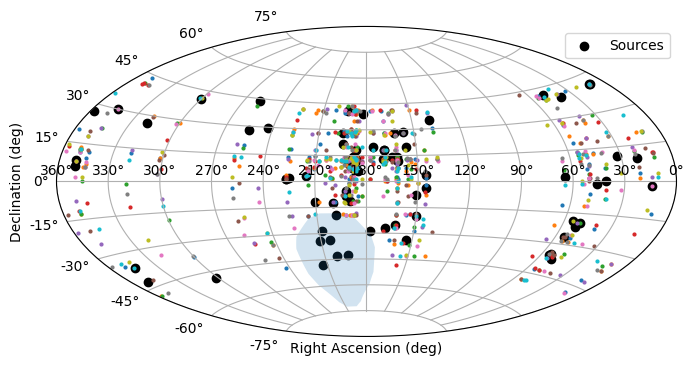

In [36]:
ra_rad = np.deg2rad(ra_true-180)
#ra_rad = np.where(ra_rad > np.pi, ra_rad - 2 * np.pi, ra_rad) #coordinates in -180,180 deg
# print(np.amin(ra_rad_rot), np.amax(ra_rad_rot))
dec_rad = np.deg2rad(dec_true)

plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection="aitoff")  # Mollweide projection
ax.scatter(-ra_rad, dec_rad, c = 'k', label='Sources')  # Plot points
ax.grid(True)
circle = plt.Circle((-np.radians(pao_hotspot_ra)+np.pi, np.radians(pao_hotspot_dec) ), np.radians(pao_hotspot_r), edgecolor = 'None', facecolor = 'C0', alpha = 0.2)
ax.add_patch(circle)

for i in range(10):
    ra_tmp = np.deg2rad(trials['ra_scrambled'][i]-180)
    dec_tmp = np.deg2rad(trials['dec_scrambled'][i])
    ax.scatter(-ra_tmp, dec_tmp, s =4) 
# Customize x-ticks for 0–360 degrees
xticks = np.radians(np.linspace(-180, 180, 13))  # Tick locations in radians
xtick_labels = [f"{int(x)}°" for x in np.linspace(360, 0, 13)]  # Tick labels in degrees
print(xtick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)  # Set the tick labels

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.legend()